In [293]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Importation des librairies

In [1]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from pandas_datareader import data as web

In [2]:
#SERIE TEMPORELLE AVEC statsmodels
import scipy.stats as st
import statsmodels 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.tsa.stattools import grangercausalitytests
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
import pmdarima as pm

In [4]:
import warnings
warnings.filterwarnings('ignore')
from PIL import Image

## telechargement des donées de tesla


In [15]:
tesla= yf.Ticker("TSLA")
tesla_data=tesla.history(period="max")

In [6]:
tesla_data.head()
# a noter que l'index est deja du type datetime

Open   High    Low  Close    Volume  Dividends  Stock Splits
Date                                                                     
2010-06-29  3.800  5.000  3.508  4.778  93831500          0           0.0
2010-06-30  5.158  6.084  4.660  4.766  85935500          0           0.0
2010-07-01  5.000  5.184  4.054  4.392  41094000          0           0.0
2010-07-02  4.600  4.620  3.742  3.840  25699000          0           0.0
2010-07-06  4.000  4.000  3.166  3.222  34334500          0           0.0

In [17]:
tesla=tesla_data[['Close']] # seul le  prix de fermeture nous interesse

##  Analyse statistique de tesla

In [9]:
def analyse_num (df) :
    num_columns=df.select_dtypes(include=['number']).columns
    df_num=df[num_columns]
    summary_df=df_num.describe().T
    summary_df.rename(columns={'50%':'Median'},inplace=True)
    summary_df.rename(columns={'25%':'Q1'},inplace=True)
    summary_df.rename(columns={'75%':'Q3'},inplace=True)
    summary_df['IQR']=summary_df['Q3']-summary_df['Q1']
    up=summary_df['Q3']+ 1.5 *(summary_df['IQR'])
    low=summary_df['Q1']- 1.5 *(summary_df['IQR'])
    summary_df['Variance']=summary_df['std']**2
    summary_df["null_values%"]=df_num.isna().sum()/summary_df['count']*100
    summary_df['outliers%']=df_num[(df_num >= up) | (df_num<=low)].count()/df_num.count()*100
    #summary_df["erreur_type"] = summary_df["std"]/np.sqrt(summary_df["count"])
    summary_df["mean_dispersion%"] = summary_df["std"]/summary_df["mean"]*100
    summary_df['skewness']=df_num.skew() # skew normal 0
    summary_df['kurtosis']=df_num.kurtosis() #kusrtosis normal 3
    return summary_df

In [10]:
tesla_stat=analyse_num(tesla).T
tesla_stat

Close
count              3002.000000
mean                150.430964
std                 265.867047
min                   3.160000
Q1                   20.949501
Median               47.086000
Q3                   69.019497
max                1229.910034
IQR                  48.069996
Variance          70685.286728
null_values%          0.000000
outliers%            18.554297
mean_dispersion%    176.736917
skewness              2.233843
kurtosis              3.736134

* les actions de tesla varient entre  3.16 et 1229 $ avec une moyenne de 150.22  et des valeurrs très dispersés( a hauteur de 176 %)
* le dataset ne contient aucune valeurs nulles mais 18% des données  sont considérés comme outliers 
* le skewness et le kurtosis nous indique une qsymetrie a droite des données de ce fait la majorité des actions semblent être plus grande que la moyenne aussi aucune valeurs trop grande ne semble être présent(kustosis)

<AxesSubplot:xlabel='Close', ylabel='Density'>

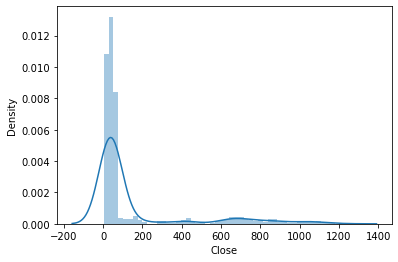

In [12]:
# distribution
sns.distplot(tesla['Close'])

on constate une forte concentration autour de valeurs proche de zero ce qui traduit que pendant lomgtemp les prix des actions tesla etaient presque insigifiante pour prendre plus tard de grandes valeurs

<AxesSubplot:ylabel='Close'>

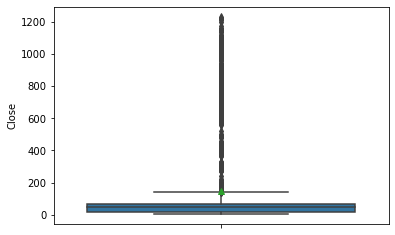

In [13]:
sns.boxplot(y=tesla["Close"], showmeans=True,)

l'etude du boxplot montre que la grande partie des donées se situent bien en dessa de la moyenne et que de très grandes valeurs existent il conviendrais de prendre les valeurs recentes pour entraînement pour éviter d'être parasité par les valeurs de l'ouverture du marché boursier de la société

## normalité et stationnarité

In [11]:
## on effectue le test de shapiro pour verifier 
'H0 :la distribution suit une loi normale'
st.shapiro(tesla['Close'])

ShapiroResult(statistic=0.5573590397834778, pvalue=0.0)

on obtient un pvaleur<0.05 on rejette donc l'hypotjèse nulle de ce fait les donées ne __sont pas normales__ et donc __pas issue du hasard__ 

In [12]:
# test augmentée de Dickey-fuller  pour la stationnarité
"HO :la série a été générée par un processus présentant une racine unitaire, et donc, qu'elle n'est pas stationnaire"
statsmodels.tsa.stattools.adfuller(tesla['Close'])[1] # on choisi l'element 1 car seul la p valeur nous interesse

0.9721056841422059

In [13]:
# test de Kwiatkowski–Phillips–Schmidt–Shin pour la stationnarité
"H0 : la série est stationnaire"
statsmodels.tsa.stattools.kpss(tesla['Close'])[1]# on choisi l'element 1 car seul la p valeur nous interesse

0.01

d'après :
 * le test de dickey-fuller (pvaleur>0.05) on ne peut rejeter l'hypothèse nulle donc la série a été générée par un processus présentant une racine unitaire, et donc, qu'elle __n'est pas stationnaire__
 * le test de Kwiatkowski–Phillips–Schmidt–Shin quand a lui retourne une pvaleur<0.05 on peut donc rejeter l'hypothèse nulle selon laquelle la serie est stationnaire de ce fait __la série n'est pas stationnaire__
 les trois test effectués confirment que la série n'est pas stationnaire et __dépend bien du temp__

## Holt winters

In [18]:
tesla_ni = tesla.reset_index()
fig = px.line(tesla_ni, x='Date', y='Close', markers=True)
fig.show()

* les actions tesla qui ne connaissaient aucune grande fluctuation depuis la creation ce sont envolée a partir du debut 2020 la periode pandemique passant de 99 à 794 dollars fin 2020 
cela s'explique par un plus grand intérêt des investisseurs de détail pour l'action, l'inclusion dans l'indice S&P 500 et un pivot général vers des actions à plus forte croissance pendant la récession de Covid-19, il y a eu des développements fondamentaux significatifs qui ont aidé Tesla au cours de cette anée notamment 
une entrée sur le marché en pleine croissance des SUV compacts et des avancées  sur leurs batterie
* le rachat de twitter fait egalement baisser le stock de tesla depuis avril 2022

In [16]:
# pour une meilleure aprehension du contexte actuelle k'ai decidé de prendre les prix de tesla à partir de jan 2021
tesla_2021=tesla.loc['2021-01-04':,:]

In [17]:
fig = px.line(tesla_2021.reset_index(), x='Date', y='Close', markers=True,title='Prix de tesla depuis janvier 2021')
fig.show()

In [18]:
tesla_2021.shape

(355, 1)

### decomposition

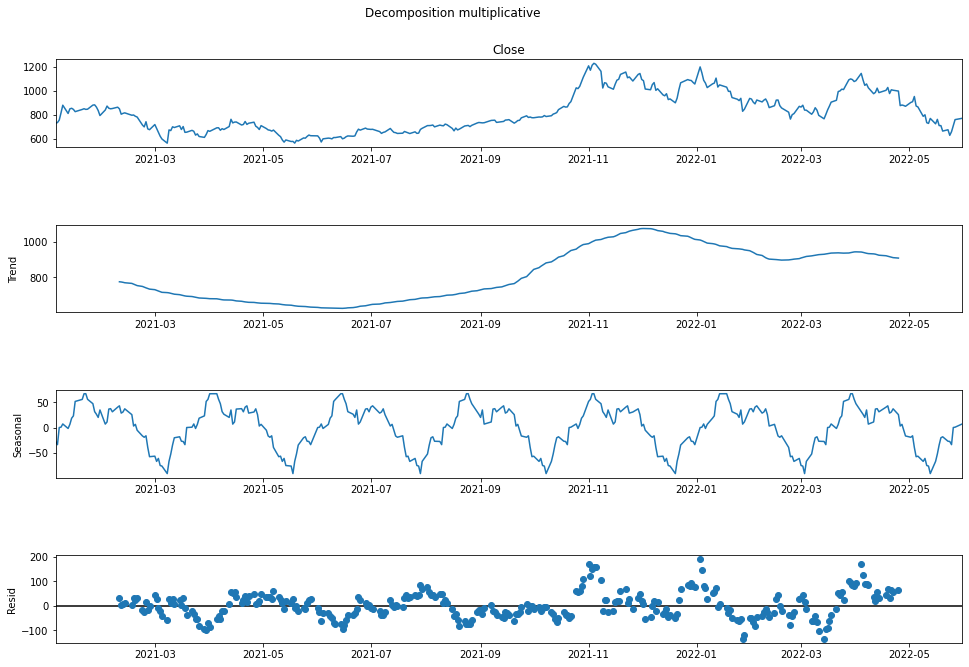

In [19]:
decomposition = seasonal_decompose(tesla_2021['Close'], model='additive',freq=50)
fig = decomposition.plot()
fig.set_figwidth(15)
fig.set_figheight(10)
fig.suptitle('Decomposition multiplicative')
plt.show()

* la decomposition nous montre une tendence en baisse jusque fin 2021  où on enregistre  une tendance globallement en hausse une decomposition multiplicative serais donc meilleur
* la saisonalité quand a elle semble avoir des patterns reccurents mais légerement differents la decomposiion n'etant pas très clair il est impossible de voir distinctement les saisons 

### split

In [20]:
tesla_ni=tesla_2021.reset_index()
tesla_ni.shape

(355, 2)

In [24]:
tesla_train=tesla_ni.loc[:2401] ## environ 80% du dataset pour entrainement
tesla_validation=tesla_ni.loc[2401:] ## 20% pour les test 

In [23]:
tesla_ni.shape

(3002, 2)

__à noter que pour la suite je ne predirai que les donées de test pour evaluation 
le meilleur modèle sera a la toute fin utilisée pour prédire le futur__ 

In [25]:
print('train :',tesla_train.shape)
print('validation :',tesla_validation.shape)

train : (2402, 2)
validation : (601, 2)


In [26]:
tesla_train=tesla_ni.set_index('Date')
tesla_validation=tesla_validation.set_index('Date')# le test set sera utilisé pour analyser les resultats du dernier modèle le plus performant

In [36]:
hw = ExponentialSmoothing(np.asarray(tesla_train['Close']),seasonal_periods=30, trend='mul', seasonal='mul').fit() 
# après plusieurs essaie j'ai trouvé ces parametres optimaux
hw_pred = hw.forecast(30)
hw_pred

array([ 571.29167136,  444.52208474,  365.82959567,  305.58261095,
        270.88330535,  263.00836914,  290.48842491,  330.36508321,
        396.87416401,  508.69113029,  661.72618245,  877.07790504,
       1120.24287132, 1440.51078137, 1766.12100305, 2194.51749069,
       2569.42459447, 3006.24229568, 3327.89286026, 3518.30946314,
       3725.77878301, 3596.49631597, 3413.63832161, 3141.94234783,
       2795.38329705, 2329.51267071, 1973.60944348, 1613.20559678,
       1262.23331374,  963.19723297])

In [38]:
y_true_=np.asarray(tesla_validation['Close'])[:30]
y_true_

array([104.97200012, 107.58399963, 103.69999695, 102.69799805,
       102.09999847, 109.44000244, 113.91200256, 114.44000244,
       112.96399689, 111.60399628, 113.37999725, 116.19799805,
       128.16200256, 130.11399841, 156.        , 177.41200256,
       146.94000244, 149.79200745, 149.61399841, 154.2559967 ,
       154.87600708, 153.45799255, 160.80000305, 160.0059967 ,
       171.67999268, 183.48399353, 179.88200378, 180.19999695,
       166.75799561, 159.98199463])

en comparant les resultats avec ceux reeles on peut se avoir un leger apercu des erreurs de prédictions de notree modèle

IndexError: index 3002 is out of bounds for axis 0 with size 3002

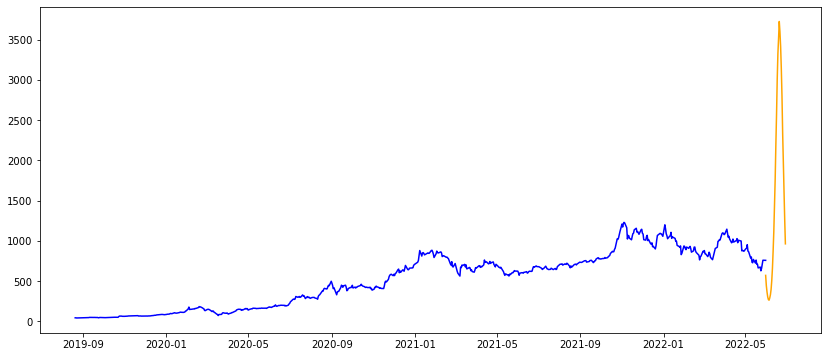

In [43]:
plt.figure(figsize=(14,6))
plt.plot(tesla_train.tail(700),label='prix d\'entrainement tesla', color='blue')
plt.plot(pd.date_range(tesla_train.index[len(tesla_train)-1], periods=30, freq='D'),hw_pred, label='Predit', color='orange')
plt.plot(pd.date_range(tesla_train.index[len(tesla_train)-1], periods=30, freq='D'),y_true_, label='valeurs de test', color='green')
plt.ylabel('prix de fermeture')
plt.xlabel('Temps')
plt.title('Prédiction des actions de tesla au cours du temps par la méthode de Holt-Winters')
plt.legend(loc='best')
plt.show()

le graphique nous montre les donées d'entrainement et de test sur 30 jours ainsi que les predictions
* on remarque que le modèle n'arrive pas à capturerparfaitment la tendance descendante et la saisonalité 

Date       Close
2997 2022-05-24  628.159973
2998 2022-05-25  658.799988
2999 2022-05-26  707.729980
3000 2022-05-27  759.630005
3001 2022-05-31  758.260010

###  evaluation

In [31]:
y_pred = hw_pred
y_true =np.asarray(tesla_validation)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE = ', rmse)
print('MAPE = ', mape)

MAE =  112.22264216798489
MSE =  18562.469006801886
RMSE =  136.244152193046
MAPE =  13.620444093997413


notre modele enregistre des erreurs moyenne de 112 dollars 
et un taux d'erreurs relatives de 13%

##  modèle AR(3) MA(3) 

In [32]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(tesla_train, order=(3,0,3))
model_fit = model.fit()
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  284
Model:                     ARMA(3, 3)   Log Likelihood               -1375.595
Method:                       css-mle   S.D. of innovations             30.534
Date:                Tue, 31 May 2022   AIC                           2767.190
Time:                        10:30:18   BIC                           2796.381
Sample:                             0   HQIC                          2778.893
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         807.5173     81.225      9.942      0.000     648.318     966.716
ar.L1.Close     1.0074      0.426      2.363      0.018       0.172       1.843
ar.L2.Close     0.5068      0.328      1.543    

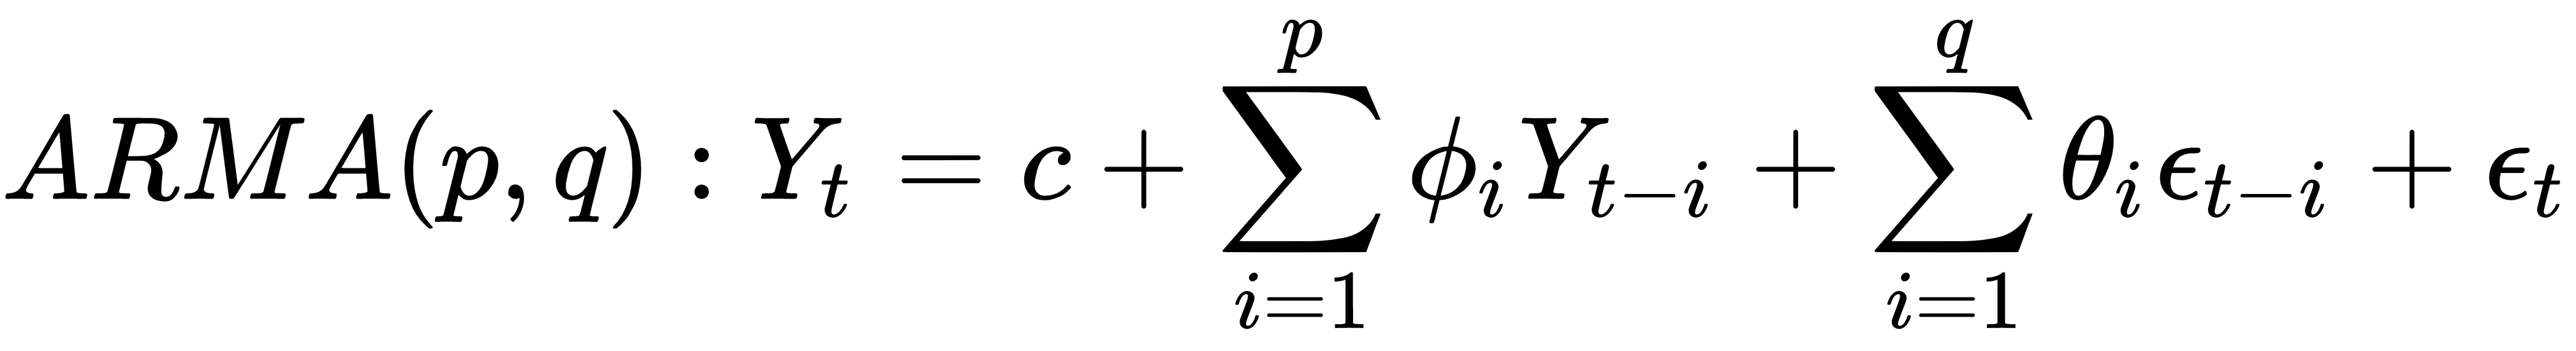

In [33]:
Image.open('1.webp')

l'equation du lodèle est donée par la formule ci dessus où :
* p = le nombre de terme autoregressif (3 dans notre modèle)
* q = le paramètre des moyennes mobiles (3 das notre modèle)
* c = la consatante
* ε = les erreurs

Interpretation des resultats du modèle :
* le modèle est un modèle ARMA evec p et q= 3 
* la method utilisé est le 'css-mle' qui veut dire 'conditional sum of squares' et  ‘maximum likelihood estimation’ la page de stats models nous indique que "la somme conditionnelle de la vraisemblance des carrés est maximisée et ses valeurs sont utilisées comme valeurs de départ pour le calcul de la vraisemblance exacte via le filtre de Kalman".
*  on a un AIC de 2768 l'AIC  signifie critère d'information d'Akaike. C'est une métrique qui vous aide à évaluer la force de votre modèle. plus il est bas mieux c'est on peut déja assumer que notre modèle ne performe pasd bien 
* les   p valeurs nous indiquent que certains coefficients sont superieur au seuil de ce fait le modèle n'est pas optimal 
* a partir des coeffictients on peut tirer l'equation suivante pour notre modèle :
    *ARMA(3,3):Yt=807.5173+1.0074*Y(t-1)+0.5068*Y(t-2)-0.5229*Y(t-3)-0.5229*£(t-1)-0.5791*£(t-2)+0.0848*£(t-3)

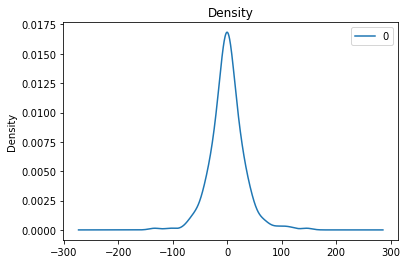

In [34]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot(kind='kde', title='Density')
plt.show()
# on plotte a densité des résidus pour voir si elle suit la loi normale

In [35]:
st.shapiro(residuals)
# les residus ne suivent donc pas la loi normale 

ShapiroResult(statistic=0.9448891878128052, pvalue=7.889611630673699e-09)

###  evaluation

In [36]:
predictions=model_fit.forecast(71)[0]

In [37]:
predictions

array([920.57309367, 919.37978117, 917.58796252, 915.97341073,
       914.06283233, 912.25688056, 910.31358547, 908.43977106,
       906.51162324, 904.63578098, 902.74875624, 900.90539093,
       899.07298583, 897.27959804, 895.50823852, 893.77311363,
       892.06525118, 890.39169768, 888.74757487, 887.13623202,
       885.5548856 , 884.00498021, 882.48480878, 880.9948395 ,
       879.53392332, 878.10203275, 876.69831287, 875.32248941,
       873.97386716, 872.65205385, 871.35644537, 870.08659791,
       868.84196335, 867.6220805 , 866.42643903, 865.25457776,
       864.10601463, 862.98029715, 861.87696635, 860.79558262,
       859.73570712, 858.69691498, 857.67878567, 856.6809097 ,
       855.70288362, 854.74431337, 853.80481163, 852.88399951,
       851.98150506, 851.09696412, 850.23001947, 849.38032117,
       848.54752611, 847.73129808, 846.9313075 , 846.14723139,
       845.37875314, 844.62556248, 843.88735529, 843.1638335 ,
       842.45470497, 841.75968337, 841.07848807, 840.41

In [38]:
y_true =np.asarray(tesla_validation)
y_true

array([[ 923.39001465],
       [ 876.34997559],
       [ 856.97998047],
       [ 821.5300293 ],
       [ 764.03997803],
       [ 800.77001953],
       [ 809.86999512],
       [ 870.42999268],
       [ 864.36999512],
       [ 879.89001465],
       [ 839.28997803],
       [ 838.28997803],
       [ 804.58001709],
       [ 824.40002441],
       [ 858.9699707 ],
       [ 838.29998779],
       [ 795.34997559],
       [ 766.36999512],
       [ 801.89001465],
       [ 840.22998047],
       [ 871.59997559],
       [ 905.39001465],
       [ 921.15997314],
       [ 993.97998047],
       [ 999.10998535],
       [1013.91998291],
       [1010.64001465],
       [1091.83996582],
       [1099.56994629],
       [1093.98999023],
       [1077.59997559],
       [1084.58996582],
       [1145.44995117],
       [1091.26000977],
       [1045.76000977],
       [1057.26000977],
       [1025.48999023],
       [ 975.92999268],
       [ 986.95001221],
       [1022.36999512],
       [ 985.        ],
       [1004.289

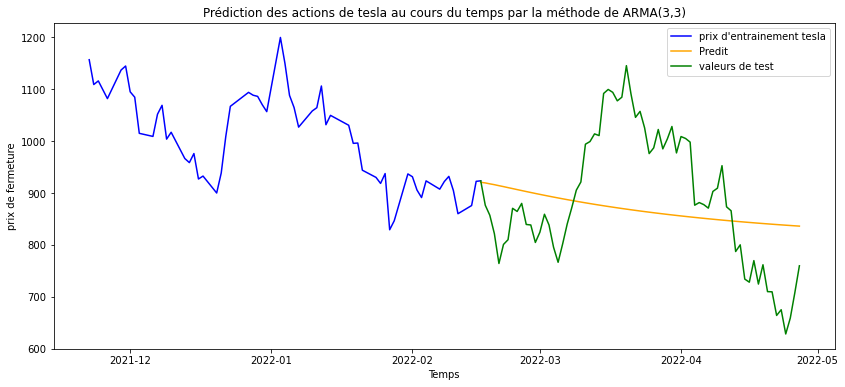

(None,)

In [78]:
plt.figure(figsize=(14,6))
plt.plot(tesla_train.tail(60),label='prix d\'entrainement tesla', color='blue')
plt.plot(pd.date_range(tesla_train.index[len(tesla_train)-1], periods=71, freq='D'),predictions, label='Predit', color='orange')
plt.plot(pd.date_range(tesla_train.index[len(tesla_train)-1], periods=71, freq='D'),y_true, label='valeurs de test', color='green')
plt.ylabel('prix de fermeture')
plt.xlabel('Temps')
plt.title('Prédiction des actions de tesla au cours du temps par la méthode de ARMA(3,3)')
plt.legend(loc='best')
plt.show(),

on remarque bien que le modèle ne capte quasiment rien de notre jeu de donée 

In [40]:
y_pred = predictions
y_true =np.asarray(tesla_validation)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE = ', rmse)
print('MAPE = ', mape)

MAE =  107.97489691510216
MSE =  15715.635863215928
RMSE =  125.36201922119764
MAPE =  12.068018998515413


* on commet une erreur relative de 12% 
* un MAE de 107.97 

## ARIMA et SARIMA

### ARIMA

In [56]:
## fonction de gridsearch
def evaluate_arima_model(train,test,arima_order):
    # make predictions
        model = ARIMA(train, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast(len(test))[0]
    # calculate out of sample error
        rmse = np.sqrt(mean_squared_error(test, yhat))
        return rmse
#  on evalue combinations of p, d and q values for an ARIMA model
def evaluate_models(train,test, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(train,test,order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA',order,'RMSE= ',mse)
                except:
                    continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [55]:
# evaluate parameters
p_values = range(10)
d_values = range(3)
q_values = range(10)
warnings.filterwarnings("ignore")
evaluate_models(tesla_train,tesla_validation, p_values, d_values, q_values)

ARIMA (0, 0, 0) MSE=  151.92876787961868
ARIMA (0, 0, 1) MSE=  151.3144209368683
ARIMA (0, 0, 2) MSE=  151.4450983820071
ARIMA (0, 0, 3) MSE=  151.31151714222202
ARIMA (0, 0, 4) MSE=  150.4807447339128
ARIMA (0, 0, 5) MSE=  150.61828045139214
ARIMA (0, 0, 6) MSE=  150.44343001073614
ARIMA (0, 1, 0) MSE=  143.20386439387417
ARIMA (0, 1, 1) MSE=  143.1409966666512
ARIMA (0, 1, 2) MSE=  141.81257152372697
ARIMA (0, 1, 3) MSE=  142.8674031374855
ARIMA (0, 1, 4) MSE=  142.77225306336166
ARIMA (0, 1, 5) MSE=  143.1088253847342
ARIMA (0, 1, 6) MSE=  143.09934157980547
ARIMA (0, 1, 7) MSE=  144.85351479134516
ARIMA (0, 1, 8) MSE=  143.77500674842022
ARIMA (0, 1, 9) MSE=  143.0368186028844
ARIMA (0, 2, 0) MSE=  137.73009589373052
ARIMA (0, 2, 1) MSE=  159.29262107177962
ARIMA (0, 2, 2) MSE=  159.30322884325037
ARIMA (0, 2, 3) MSE=  157.84257486737113
ARIMA (0, 2, 4) MSE=  158.53456431851905
ARIMA (0, 2, 5) MSE=  158.72316747896397
ARIMA (0, 2, 6) MSE=  155.52963970859977
ARIMA (0, 2, 7) MSE=  1

ARIMA (7, 2, 0) MSE=  172.62088100446002
ARIMA (7, 2, 1) MSE=  152.0711397167495
ARIMA (7, 2, 2) MSE=  152.7408961272922
ARIMA (7, 2, 3) MSE=  150.1285740485776
ARIMA (7, 2, 4) MSE=  152.21474349574146
ARIMA (8, 0, 0) MSE=  128.11244841946447
ARIMA (8, 0, 1) MSE=  127.43346804883991
ARIMA (8, 0, 2) MSE=  126.6521939760605
ARIMA (8, 0, 3) MSE=  125.77280421690939
ARIMA (8, 0, 7) MSE=  124.40129231720738
ARIMA (8, 0, 8) MSE=  124.39759643583798
ARIMA (8, 0, 9) MSE=  124.72612173088986
ARIMA (8, 1, 0) MSE=  143.52548562920654
ARIMA (8, 1, 1) MSE=  141.95070122719858
ARIMA (8, 1, 2) MSE=  141.92371988969148
ARIMA (8, 1, 3) MSE=  141.91642547533527
ARIMA (8, 1, 4) MSE=  146.24650630037897
ARIMA (8, 1, 5) MSE=  146.49305997885196
ARIMA (8, 1, 6) MSE=  146.8487099795476
ARIMA (8, 1, 7) MSE=  156.61962803812807
ARIMA (8, 1, 8) MSE=  157.88305439665294
ARIMA (8, 1, 9) MSE=  157.54077378061635
ARIMA (8, 2, 0) MSE=  173.55531255794435
ARIMA (8, 2, 1) MSE=  157.70057056336375
ARIMA (8, 2, 2) MSE= 

le meilleur modèle semble etre un modele ARMA(6,4) en se basant sur les RMSE

In [58]:
# fit avec les parametres optimaux
model2 = ARIMA(tesla_train, order=(6,0,4))
model_fit2 = model2.fit()
print(model_fit2.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                  284
Model:                     ARMA(6, 4)   Log Likelihood               -1368.844
Method:                       css-mle   S.D. of innovations             29.699
Date:                Tue, 31 May 2022   AIC                           2761.688
Time:                        10:58:31   BIC                           2805.476
Sample:                             0   HQIC                          2779.244
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const         816.1895    147.270      5.542      0.000     527.545    1104.834
ar.L1.Close     0.7335      0.013     56.727      0.000       0.708       0.759
ar.L2.Close     0.9247      0.061     15.206    

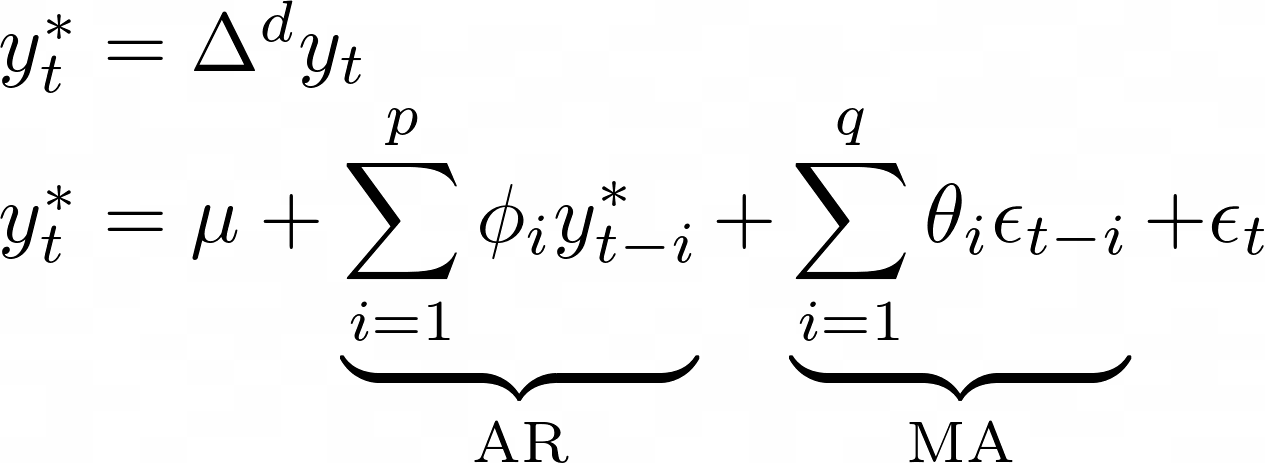

In [67]:
Image.open('2.png')

 tout comme pour le  precedant ce modèle utilise la formule ci-dessus  :
 * on remarque que la fonction de recherche a trouvé de meilleur resultats sans paramètres de differienciation les series choisi sont alors peut être deja stationnaire de ce fait le modèle utilisera la formule du modèle ARMA 
  * le modèle se base sur 6 jours d'autoregression et les residus des 4 jours précedents en appliquant la formule ci-dessus et les coefficients du resultats on pourras déterminer la formule du modèle

In [59]:
y_pred =model_fit2.forecast(71)[0]
y_true =np.asarray(tesla_validation)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE = ', rmse)
print('MAPE = ', mape)

MAE =  105.58785303627113
MSE =  15150.651160962467
RMSE =  123.08798138308414
MAPE =  12.255240534513142


le modèle performe legerement mieux que le précédent en se basant sur les metrics

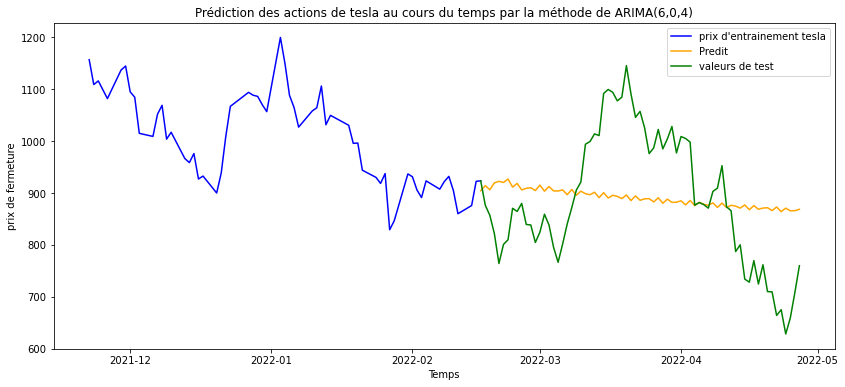

(None,)

In [73]:
plt.figure(figsize=(14,6))
plt.plot(tesla_train.tail(60),label='prix d\'entrainement tesla', color='blue')
plt.plot(pd.date_range(tesla_train.index[len(tesla_train)-1], periods=71, freq='D'),y_pred, label='Predit', color='orange')
plt.plot(pd.date_range(tesla_train.index[len(tesla_train)-1], periods=71, freq='D'),y_true_, label='valeurs de test', color='green')
plt.ylabel('prix de fermeture')
plt.xlabel('Temps')
plt.title('Prédiction des actions de tesla au cours du temps par la méthode de ARIMA(6,0,4)')
plt.legend(loc='best')
plt.show(),

le modèle s'ameliore et capte mieux le dataset mais est encore très loin d'être bon

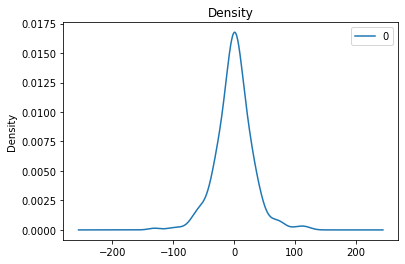

In [70]:
residuals = pd.DataFrame(model_fit2.resid)
residuals.plot(kind='kde', title='Density')
plt.show()
# on plotte a densité des résidus pour voir si elle suit la loi normale

In [72]:
st.shapiro(residuals)
# les residus ne suivent donc pas la loi normale le modèle n'explique donc pas certains phénomene

ShapiroResult(statistic=0.9580869078636169, pvalue=2.6935794039673056e-07)

##  SARIMA

In [75]:
### essayons d'ajouter une saisonnalité a notre modele pour voir si il performe mieux

In [101]:
## auto arima avec des paramètres definis pour tirer le modele optimum
smodel = pm.auto_arima(tesla_train, start_p=1, start_q=1,
                       max_q=10,max_d=5,max_p=10,
                       start_P=1 ,start_Q=1,max_D=5,
                       max_Q=10,max_P=10,
                        m=12, seasonal=True,
                       test='adf',
                       max_order=None,
                       n_jobs=-1,
                       #######
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=2745.769, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2747.879, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=2748.823, Time=0.13 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=2749.581, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2746.018, Time=0.01 sec
 ARIMA(1,1,1)(0,0,1)[12] intercept   : AIC=2751.391, Time=0.25 sec
 ARIMA(1,1,1)(1,0,0)[12] intercept   : AIC=2750.643, Time=0.22 sec
 ARIMA(1,1,1)(2,0,1)[12] intercept   : AIC=2740.988, Time=0.73 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=2739.735, Time=0.58 sec
 ARIMA(1,1,1)(3,0,0)[12] intercept   : AIC=2741.165, Time=1.31 sec
 ARIMA(1,1,1)(3,0,1)[12] intercept   : AIC=2742.975, Time=1.64 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=2737.875, Time=0.29 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=2748.805, Time=0.15 sec
 ARIMA(0,1,1)(3,0,0)[12] intercept   : AIC=2739.296, Time=0.57 sec
 ARIMA(0,1,1)(2,0,1

selon la fonction le meilleur modèle n'utilise aucun ordre d'autoregression et d'erreurs , une differienciation et 2 comme terme d'autoregression saisonier

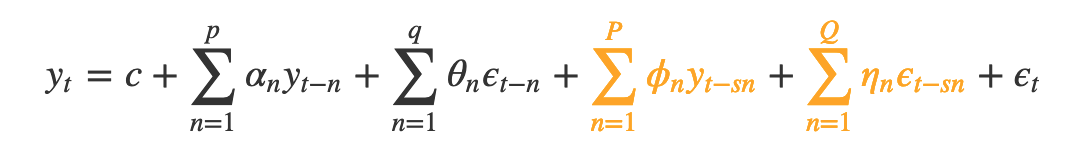

In [88]:
Image.open('3.png')

formula :
    yt*=delta(Yt) <br/>
    yt=c+0.0752*Y(t-12)+£(t)

In [85]:
smodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  284
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -1364.172
Date:                            Tue, 31 May 2022   AIC                           2734.343
Time:                                    15:11:31   BIC                           2745.279
Sample:                                         0   HQIC                          2738.728
                                            - 284                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0752      0.068      1.099      0.272      -0.059       0.209
ar.S.L24       0.2275      0.051      4.469      0.000       0.128       0.327
sigma2       896.0850     42.397     21.135      0.000     812.988     979.182
===================================================================================
Ljung-Box (L1) (Q):                   0.36   Jarque-Bera (JB):               226.12
Prob(Q):                              0.55   Prob(JB):                         0.00
Heteroskedasticity (H):               2.17   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

les analyses des pvaleurs revelent que le coeficient du terme de seasonalité n'est pas optimal

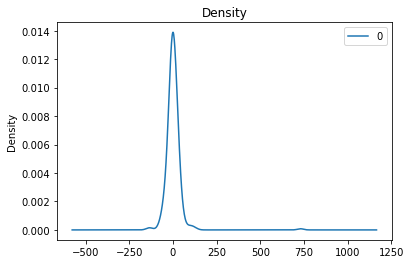

In [115]:
residuals = pd.DataFrame(smodel.resid())
residuals.plot(kind='kde', title='Density')
plt.show()

In [116]:
st.shapiro(residuals)

ShapiroResult(statistic=0.4755673408508301, pvalue=4.263322302848166e-28)

les residus ne sont pas normale

####  evaluation

In [104]:
y_pred =smodel.predict(len(tesla_validation))
y_true =np.asarray(tesla_validation)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE = ', rmse)
print('MAPE = ', mape)

MAE =  105.77465753608386
MSE =  16188.207560517412
RMSE =  127.23288710281399
MAPE =  11.807150624698727


ce dernier modèle performe mieux que le precedant avec un MAE de 105 et  un MAPE de 11.80

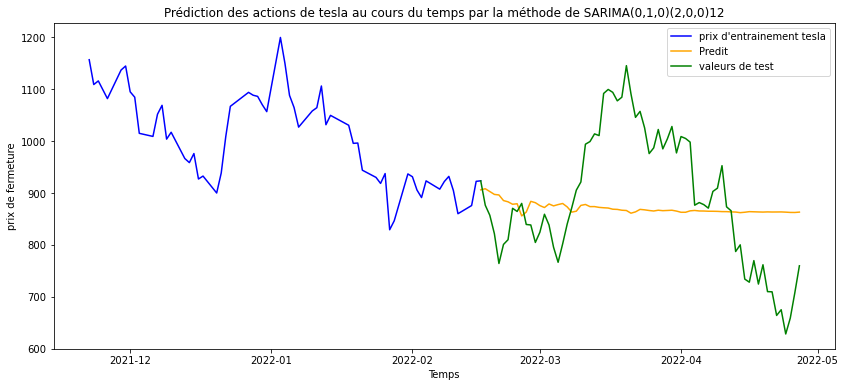

(None,)

In [118]:
## visyualisation des performances de notre modèle
plt.figure(figsize=(14,6))
plt.plot(tesla_train.tail(60),label='prix d\'entrainement tesla', color='blue')
plt.plot(pd.date_range(tesla_train.index[len(tesla_train)-1], periods=71, freq='D'),y_pred, label='Predit', color='orange')
plt.plot(pd.date_range(tesla_train.index[len(tesla_train)-1], periods=71, freq='D'),y_true, label='valeurs de test', color='green')
plt.ylabel('prix de fermeture')
plt.xlabel('Temps')
plt.title('Prédiction des actions de tesla au cours du temps par la méthode de SARIMA(0,1,0)(2,0,0)12')
plt.legend(loc='best')
plt.show(),

## Causalité

In [91]:
## creation d'un data frame regroupant les cours des actions des differents stock de 2021 a aujourdui 
stock= ['AAPL', 'AMZN', 'MSFT', 'TSLA', 'FB', 'GOOG', 'NFLX']

In [98]:
path = 'C:/Users/ismae/Documents/#IAS/Time Series & Data Analysis'
def save_to_csv(ticker, syear, smonth, sday, eyear, emonth, eday):
    
    # Definit la période de temps à utiliser
    start = dt.datetime(syear, smonth, sday)
    end = dt.datetime(eyear, emonth, eday)
    
    # Lis les données dans le DataFrame
    df = web.DataReader(ticker, 'yahoo', start, end)   
   
    df.to_csv(path+ticker + '.csv')
    return df
def download_multiple_stocks(syear, smonth, sday, eyear, emonth, eday, *args):
    for x in args:
        save_to_csv(x, syear, smonth, sday, eyear, emonth, eday)
download_multiple_stocks(2021, 1, 1, 2022,5,27, *stock)
def merge_df_by_column_name(col_name, syear, smonth, sday, eyear, emonth, eday, *stock):
    # Conservera les données de toutes les trames de données avec le même nom de colonne
    mult_df = pd.DataFrame()
    
    start = f"{syear}-{smonth}-{sday}"
    end = f"{eyear}-{emonth}-{eday}"
    
    for x in stock:
        mult_df[x] = web.DataReader(x, 'yahoo', start, end)[col_name]
        
    return mult_df

In [112]:
data = merge_df_by_column_name('Close',2021,1,1,2022,5,27,*stock)
data=data.reset_index()
data2=data.drop('Date',axis=1)

In [141]:
## test de causalité
maxlag=15
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
   
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df
granger=grangers_causation_matrix(data2, variables = data2.columns)

In [142]:
granger.loc['TSLA_y']

AAPL_x    0.4583
AMZN_x    0.0211
MSFT_x    0.0034
TSLA_x    1.0000
FB_x      0.0303
GOOG_x    0.0637
NFLX_x    0.0001
Name: TSLA_y, dtype: float64

en analysant les p valeurs on retiendra que pour ameliorer notre modele il serais interessant d'inclure :
* microsoft
* amazon 
* facebook
* netflix

pvaleur<0.05

### Ajout des variables exogenes pour ameliorations

In [147]:
target=data[['TSLA']]

In [149]:
exog = data[['MSFT','AMZN','FB','NFLX']]
exog.head()

MSFT         AMZN          FB        NFLX
Date                                                       
2021-01-04  217.690002  3186.629883  268.940002  522.859985
2021-01-05  217.899994  3218.510010  270.970001  520.799988
2021-01-06  212.250000  3138.379883  263.309998  500.489990
2021-01-07  218.289993  3162.159912  268.739990  508.890015
2021-01-08  219.619995  3182.699951  267.570007  510.399994

In [173]:
n_periods=71
target_train= target.drop(target.index[-n_periods:])
target_test=target[-n_periods:]
exog_train= exog.drop(exog.index[-n_periods:])
exog_test=exog[-n_periods:]

In [179]:
## auto arima avec des paramètres definis pour tirer le modele optimum
smodel2 = pm.auto_arima(target_train, start_p=1, start_q=1,
                       max_q=10,max_d=5,max_p=10,
                       start_P=1 ,start_Q=1,max_D=5,
                       max_Q=10,max_P=10,X=exog_train,
                        m=12, seasonal=True,
                       test='adf',
                       max_order=None,
                       n_jobs=-1,
                       #######
                         trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=2700.266, Time=0.85 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=3267.262, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=2700.169, Time=0.85 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=3067.175, Time=0.67 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3265.305, Time=0.31 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=2700.607, Time=0.31 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=2697.104, Time=2.49 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=2696.605, Time=3.31 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=2696.108, Time=5.58 sec
 ARIMA(1,0,0)(5,0,0)[12] intercept   : AIC=2697.645, Time=8.52 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=2697.739, Time=6.01 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=2698.886, Time=3.49 sec
 ARIMA(1,0,0)(5,0,1)[12] intercept   : AIC=2693.818, Time=9.02 sec
 ARIMA(1,0,0)(6,0,1)[12] intercept   : AIC=2699.644, Time=15.30 sec
 ARIMA(1,0,0)(5,0,

In [180]:
smodel2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  283
Model:             SARIMAX(1, 0, 0)x(5, 0, [1], 12)   Log Likelihood               -1333.935
Date:                              Tue, 31 May 2022   AIC                           2691.870
Time:                                      20:30:43   BIC                           2735.615
Sample:                                           0   HQIC                          2709.410
                                              - 283                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
MSFT           2.1192      0.524      4.047      0.000       1.093       3.145
AMZN           0.0472      0.038      1.235      0.217      -0.028       0.122
FB            -0.1095      0.324     -0.338      0.736      -0.746       0.526
NFLX           0.1704      0.170      1.004      0.315      -0.162       0.503
ar.L1          0.9462      0.019     50.631      0.000       0.910       0.983
ar.S.L12       0.9294      0.135      6.862      0.000       0.664       1.195
ar.S.L24       0.0641      0.107      0.602      0.547      -0.145       0.273
ar.S.L36      -0.0101      0.096     -0.106      0.916      -0.198       0.178
ar.S.L48       0.0485      0.117      0.416      0.678      -0.180       0.277
ar.S.L60      -0.2040      0.087     -2.345      0.019      -0.374      -0.033
ma.S.L12      -0.8660      0.129     -6.728      0.000      -1.118      -0.614
sigma2       704.0334     45.312     15.537      0.000     615.223     792.844
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               407.05
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               2.38   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

on obtient les coefficients du meilleur modèle avec leurs coefficients respectifs

###  evaluation

In [184]:
#predictions = results5.get_prediction(exog=exog).predicted_mean
y_pred =smodel2.predict(len(target_test),X=exog_test)
y_true =np.asarray(target_test)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAE = ', mae)
print('MSE = ', mse)
print('RMSE = ', rmse)
print('MAPE = ', mape)

MAE =  118.19574824755827
MSE =  20963.44739036854
RMSE =  144.78759404855285
MAPE =  16.21695007538409


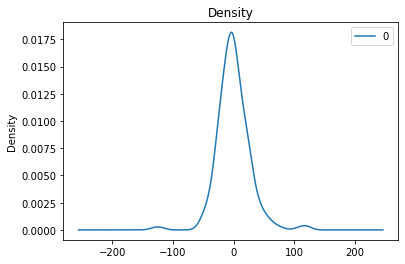

In [193]:
residuals = pd.DataFrame(smodel2.resid())
residuals.plot(kind='kde', title='Density')
plt.show()

In [194]:
st.shapiro(residuals)

ShapiroResult(statistic=0.9189910292625427, pvalue=2.9492953218523965e-11)

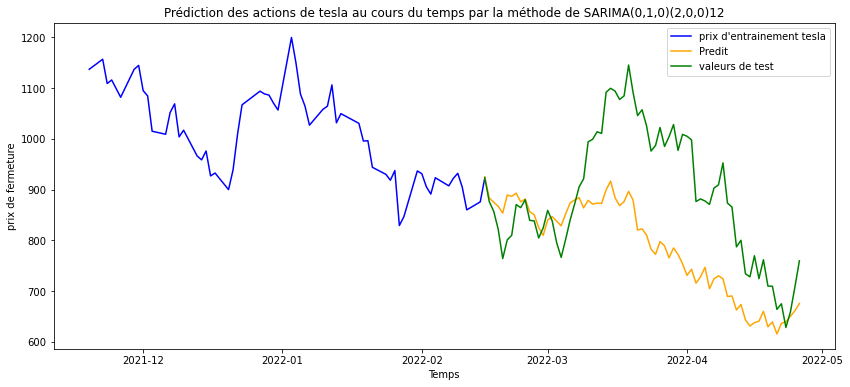

(None,)

In [191]:
## visyualisation des performances de notre modèle
plt.figure(figsize=(14,6))
plt.plot(target_train.tail(60),label='prix d\'entrainement tesla', color='blue')
plt.plot(pd.date_range(target_train.index[len(target_train)-1], periods=71, freq='D'),y_pred, label='Predit', color='orange')
plt.plot(pd.date_range(target_train.index[len(target_train)-1], periods=71, freq='D'),y_true, label='valeurs de test', color='green')
plt.ylabel('prix de fermeture')
plt.xlabel('Temps')
plt.title('Prédiction des actions de tesla au cours du temps par la méthode de SARIMA(0,1,0)(2,0,0)12')
plt.legend(loc='best')
plt.show(),

une evaluation de ce modèle semble montrer qu'il capte légerement mieux les aleas du dataset cepdandant les donées ne sont pas normales et les metrics indiquent qu'il performe moins bien que le modèle sans variables exogenes 

##  Neural Prophet

In [8]:
from neuralprophet import NeuralProphet

In [9]:
tesla.reset_index(inplace=True)
tesla_fb=tesla.rename(columns={'Date':'ds','Close':'y'})

In [10]:
m=NeuralProphet()
metrics = m.fit(tesla_fb)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.369% of the data.
INFO - (NP.df_utils._infer_frequency) - Dataframe freq automatically defined as B
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 141


  0%|          | 0/137 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.76E-02, min: 1.66E-01


  0%|          | 0/137 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 7.76E-02, min: 1.66E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 8.44E-02
Epoch[141/141]: 100%|██████████| 141/141 [00:25<00:00,  5.43it/s, SmoothL1Loss=0.00248, MAE=34.4, RMSE=55.3, RegLoss=0]


In [12]:
# Predictions
future = m.make_future_dataframe(tesla_fb, periods=30, n_historic_predictions=700) 
prediction = m.predict(future)

INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.369% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.438% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B
INFO - (NP.df_utils._infer_frequency) - Major frequency B corresponds to 96.438% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - B


In [13]:
prediction

ds          y        yhat1  residual1        trend  season_yearly  \
0   2019-08-21  44.166000    82.530945  38.364944   227.709412      -2.939028   
1   2019-08-22  44.430000    81.507332  37.077332   228.188812      -2.495462   
2   2019-08-23  42.279999    80.951591  38.671593   228.668304      -2.101790   
3   2019-08-26  43.000000    85.308823  42.308823   230.106415      -1.246151   
4   2019-08-27  42.816002    86.159134  43.343132   230.586014      -1.075227   
..         ...        ...          ...        ...          ...            ...   
725 2022-07-06        NaN  1127.619751        NaN  1276.305420      -6.446145   
726 2022-07-07        NaN  1126.410034        NaN  1277.443970      -6.847937   
727 2022-07-08        NaN  1125.664429        NaN  1278.581787      -7.302425   
728 2022-07-11        NaN  1129.547363        NaN  1281.996338      -8.897482   
729 2022-07-12        NaN  1130.305298        NaN  1283.134521      -9.477633   

     season_weekly  
0      -142.239441  
1      -144.186020  
2      -145.614929  
3      -143.551437  
4      -143.351639  
..             ...  
725    -142.239441  
726    -144.186020  
727    -145.614929  
728    -143.551437  
729    -143.351639  

[730 rows x 7 columns]

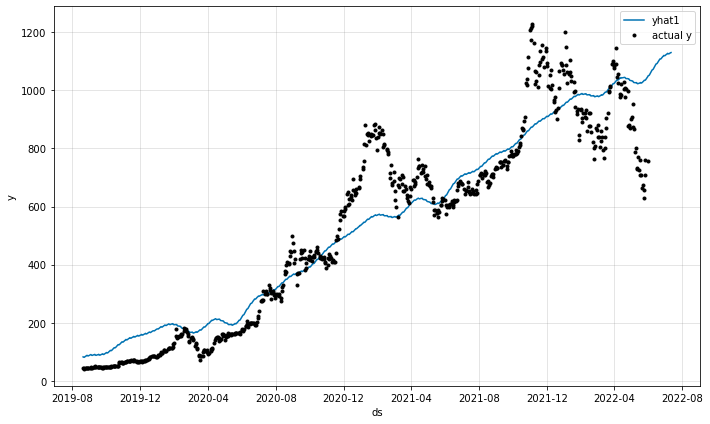

In [14]:
fig_forecast = m.plot(prediction)

le modèle neural a l'air de mieux performer avec les metrics mais la visualisation semble prouver que le modèle ne capture que la tendance descendante du dataset

## Comparaison

en se basant sur les metrics le modèle a l'aide de  neural prophet semble être le meilleur avec un MAE de 35
suivi par le modèle sarima et les variables exogènes 

## Conclusion 

In [291]:
predictions=prediction.iloc[-30:]
predictions[predictions['yhat1']==min(predictions['yhat1'])]

ds   y       yhat1  residual1       trend  season_yearly  \
355 2022-06-01 NaN  1050.15625        NaN  900.568542     -43.476768   

     season_weekly  
355     193.064468

In [292]:
predictions[predictions['yhat1']==max(predictions['yhat1'])]

ds   y        yhat1  residual1       trend  season_yearly  \
384 2022-07-12 NaN  1130.297363        NaN  947.220337      -9.767547   

     season_weekly  
384     192.844482

d'après le modèle  il serais judicieux  d'acheter le 01 juin et de revendre le 12 juillet 
pour des benefices estimées a environ 80 $